In [25]:
library(htmltools)
library(IRdisplay)

IRdisplay::display_html(HTML("
<style>
.simulation-box {
  border-left: 6px solid #c0392b;
  background: linear-gradient(135deg, #fff5f5, #ffffff);
  padding: 18px 22px;
  margin-bottom: 24px;
  border-radius: 6px;
  font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', sans-serif;
}

.simulation-title {
  font-size: 1.6em;
  font-weight: 600;
  margin-bottom: 8px;
  color: #2c2c2c;
}

.simulation-meta {
  font-size: 0.95em;
  color: #555;
  margin-bottom: 12px;
}

.simulation-meta span {
  margin-right: 12px;
}

.simulation-section {
  margin-top: 10px;
  font-size: 1.02em;
  color: #333;
}

.deps-box {
  border: 2px solid #1f4fd8;
  background: linear-gradient(135deg, #f4f7ff, #ffffff);
  padding: 18px 22px;
  margin: 24px 0;
  border-radius: 8px;
  font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', sans-serif;
}

.deps-title {
  font-weight: 600;
  font-size: 1.2em;
  margin-bottom: 10px;
  color: #1f4fd8;
  text-align: center;
}

.deps-code {
  background-color: #f0f2f5;
  padding: 12px 14px;
  border-radius: 6px;
  font-family: ui-monospace, Menlo, Consolas, monospace;
  font-size: 0.95em;
}
</style>
"))

In [17]:
IRdisplay::display_html(HTML("
<div class='simulation-box'>

  <div class='simulation-title'>
    Regressão Heteroscedástica com Redes Neurais
  </div>

  <div class='simulation-meta'>
    <span><b>Linguagem:</b> R</span>
    <span><b>Framework:</b> torch</span>
    <span><b>Ambiente:</b> Jupyter Notebook</span>
  </div>

  <div class='simulation-section'>
    <b>Objetivo</b>
    <p>
      Demonstrar a aprendizagem simultânea da média condicional
      <i>f(x)</i> e da variância condicional
      <i>σ²(x)</i> em um problema de regressão heteroscedástica.
    </p>
  </div>

  <div class='simulation-section'>
    <b>Características do experimento</b>
    <ul>
      <li>Dados sintéticos com ruído dependente da entrada</li>
      <li>Rede neural com duas saídas: μ(x) e σ²(x)</li>
      <li>Função de custo baseada em log-verossimilhança Gaussiana</li>
      <li>Visualização dinâmica do treinamento e geração de GIF</li>
    </ul>
  </div>

</div>
"))

Regressão Heteroscedástica com Redes Neurais
 

 
 Linguagem: R 
 Framework: torch 
 Ambiente: Jupyter Notebook 
 

 
 Objetivo 
 
 Demonstrar a aprendizagem simultânea da média condicional
 f(x) e da variância condicional
 σ²(x) em um problema de regressão heteroscedástica.
 
 

 
 Características do experimento 
 
 Dados sintéticos com ruído dependente da entrada 
 Rede neural com duas saídas: μ(x) e σ²(x) 
 Função de custo baseada em log-verossimilhança Gaussiana 
 Visualização dinâmica do treinamento e geração de GIF

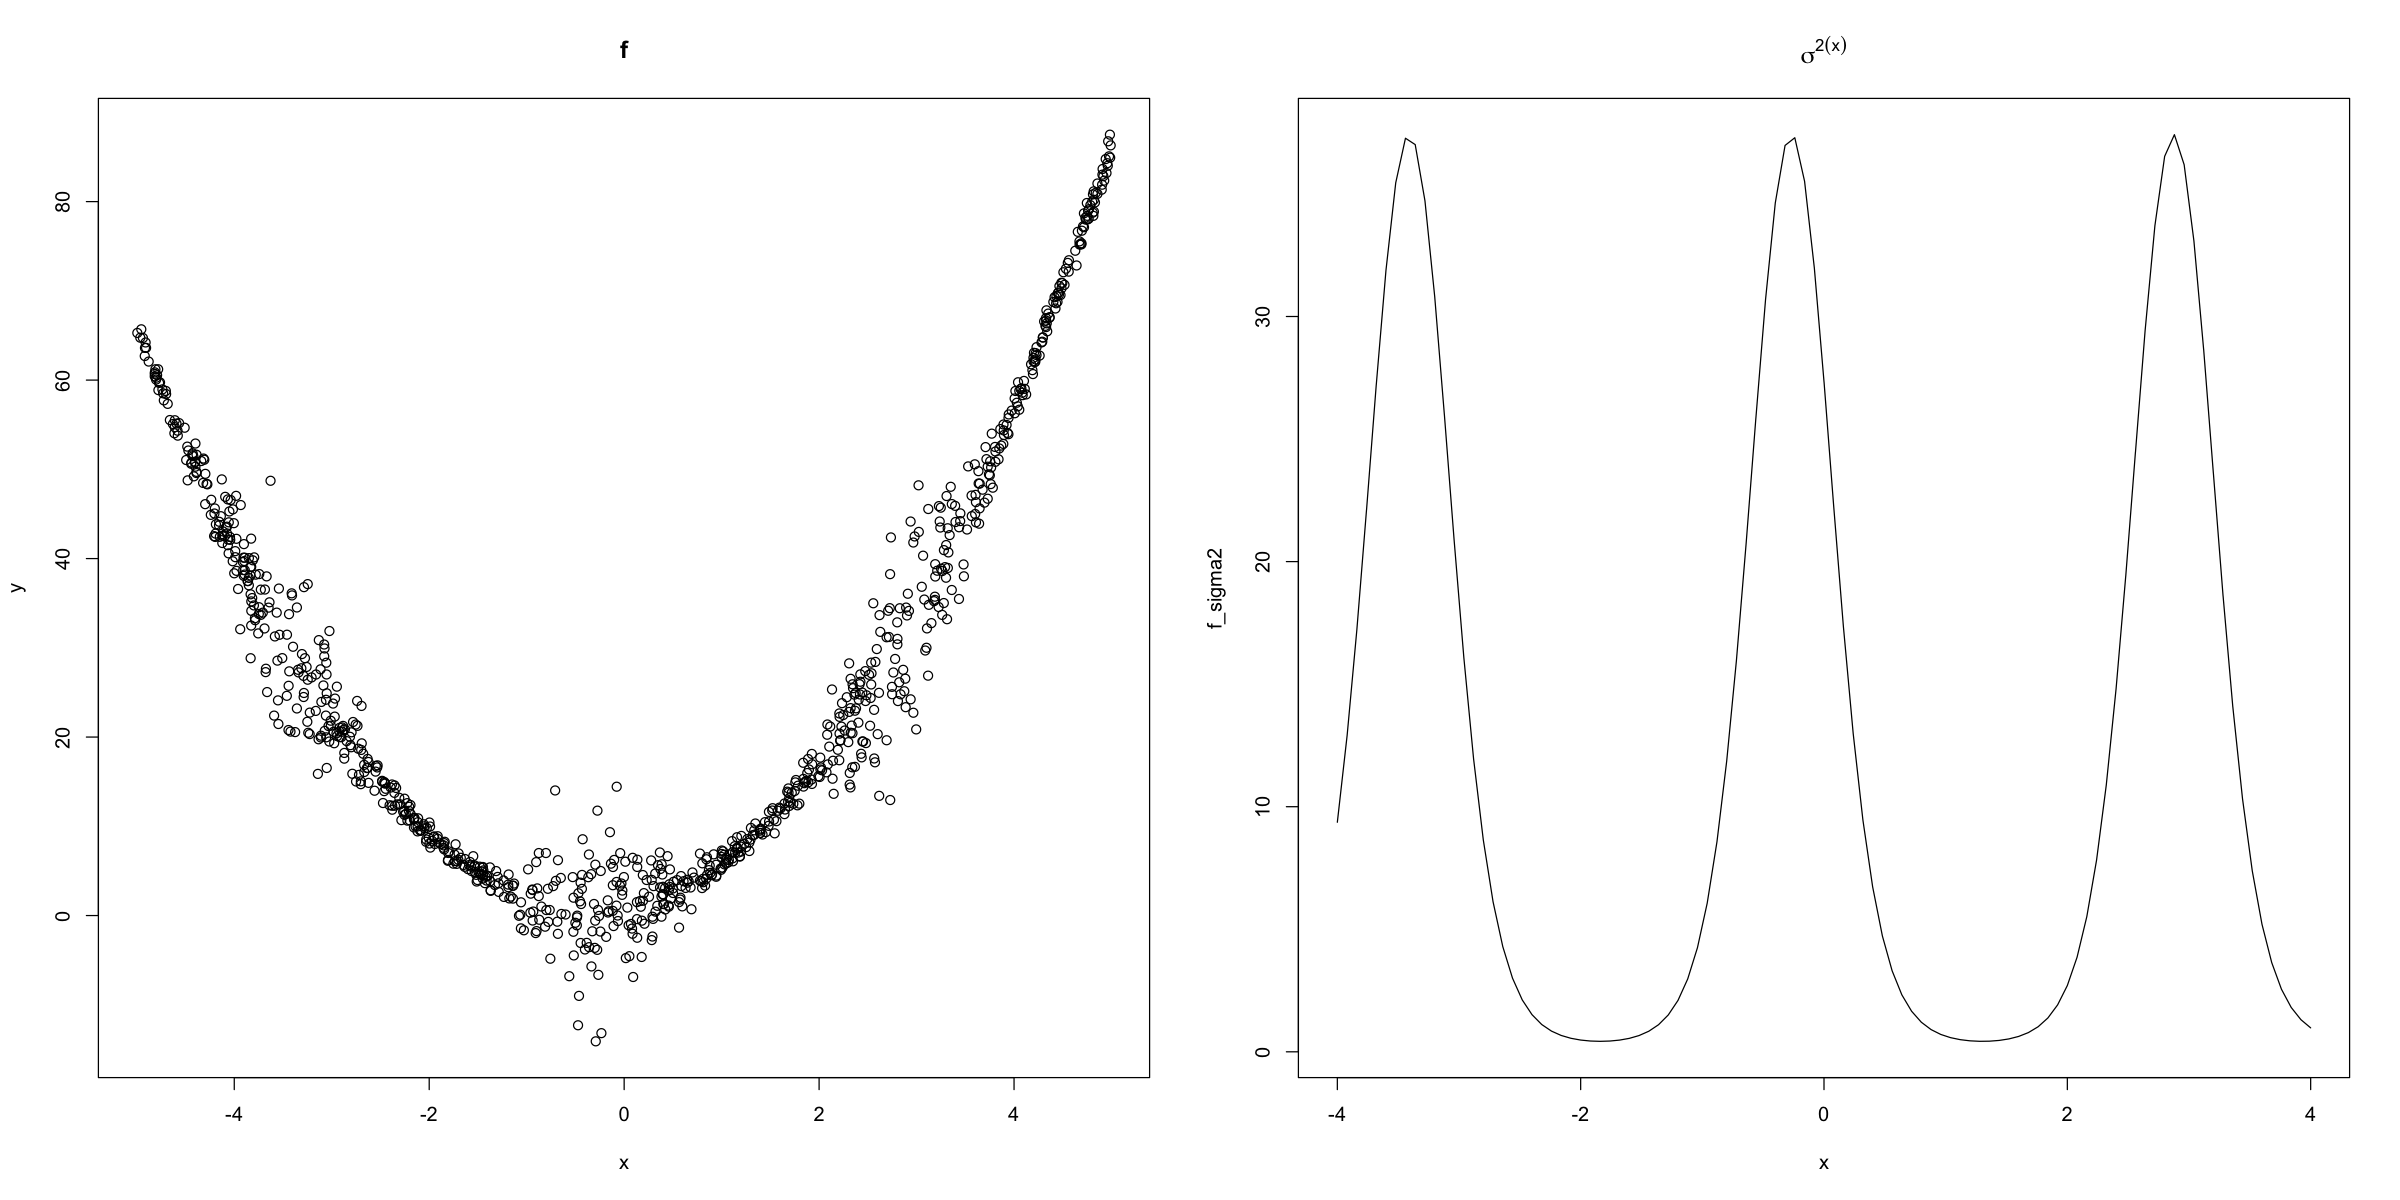

In [49]:
library(torch)

n = 1000
x = runif(n, -5,5)
f = function(x) 1 + 3 * x^2 + 2 * x
f_sigma2 = function(x) 4*exp(1*sin(1 + 2*x) + 2*cos(1 + 2*x))
# plot(f_sigma2, xlim=c(-4,4))
y = f(x) + rnorm(n)*sqrt(f_sigma2(x))
# plot(y~x)

options(
  repr.plot.width = 20,
  repr.plot.height = 10
)
par(mfrow = c(1, 2))

plot(y ~ x, main = "f")
plot(f_sigma2, xlim = c(-4, 4), main = expression(sigma^2(x)))
par(mfrow = c(1, 1))  # (opcional) volta ao normal

model_mu_sigma2 <- torch::nn_module (
  initialize = function (in_dim, out_dim, N) {
    self$seq_mu <- torch::nn_sequential (
      torch::nn_linear(in_dim, round(N)),
      torch::nn_gelu(),
      torch::nn_linear(round(N), out_dim)
    )
    self$seq_logsig2 <- torch::nn_sequential(
      torch::nn_linear(in_dim, round(N)),
      torch::nn_gelu(),
      torch::nn_linear(round(N), out_dim)
    )
  },
  forward = function(x) {
    mu <- self$seq_mu(x)
    sigma2 <- torch_exp(self$seq_logsig2(x))
    return(list(mu, sigma2))
  }
)

In [52]:
estimacao = function(x, y, model, epochs = 3000, lr = 1e-3, print_each = 10,
                             f, f_sigma2, make_gif = FALSE, gif_every = 10, gif_name = "train.gif") {

  n = length(x)

  xx = torch::torch_tensor(matrix(x, ncol=1), dtype=torch::torch_float())
  yy = torch::torch_tensor(matrix(y, ncol=1), dtype=torch::torch_float())

  optim = optim_adam(model$parameters, lr = lr)

  x1 = seq(-5,5, length.out = 300)
  x1t = torch::torch_tensor(matrix(x1, ncol=1), dtype=torch::torch_float())

  loss_store = rep(NA, epochs)

  # (opcional) frames para gif
  frame_dir = file.path(tempdir(), "frames_hetero")
  if(make_gif) {
    dir.create(frame_dir, showWarnings = FALSE, recursive = TRUE)
  }
  frame_idx = 0

  for(i in 1:epochs) {

    loss_i = 0

    for(j in 1:n) {

      fit = model(xx[j, ..])
      yhat = fit[[1]]
      sigma2 = fit[[2]]

      L = (0.5*torch::torch_log(sigma2) + 0.5*(yy[j, ..] - yhat)^2 / sigma2)$sum()

      optim$zero_grad()
      L$backward()
      optim$step()

      loss_i = loss_i + as.numeric(L$item())
    }

    loss_store[i] = loss_i/n

    # update visual
    if(i %% print_each == 0) {

      with_no_grad({
        fit1 = model(x1t)
        mu1 = as.numeric(fit1[[1]]$squeeze())
        s21 = as.numeric(fit1[[2]]$squeeze())
      })

      # limpa e redesenha (sem repetir output)
      IRdisplay::clear_output(wait = TRUE)

      cat(sprintf("Epoca: %d   Perda: %.6f\n", i, loss_store[i]))

      panel = make_panel(x, y, x1, mu1, s21, loss_store, i, f, f_sigma2)
      print(panel)

      # frames do gif (opcional)
      if(make_gif && (i %% gif_every == 0)) {
        frame_idx = frame_idx + 1
        png(file.path(frame_dir, sprintf("frame_%05d.png", frame_idx)), width=1600, height=450, res=150)
        cat(sprintf("Epoca: %d   Perda: %.6f\n", i, loss_store[i]))
        print(panel)
        dev.off()
      }
    }
  }

  # gerar gif (opcional)
  if(make_gif) {
    frames = list.files(frame_dir, pattern="\\.png$", full.names=TRUE)
    gifski::gifski(png_files = frames, gif_file = gif_name, width = 1600, height = 450, delay = 0.08)
    cat("\nGIF gerado em: ", gif_name, "\n")
  }

  invisible(list(model = model, loss_store = loss_store))
}

In [53]:
library(IRdisplay)
library(ggplot2)
library(patchwork)
library(gifski)

In [54]:
make_panel = function(x, y, x1, mu1, s21, loss_store, i, f, f_sigma2) {

  df_data = data.frame(x = x, y = y)
  df_grid = data.frame(
    x = x1,
    mu = mu1,
    s2 = s21,
    ftrue = f(x1),
    s2true = f_sigma2(x1)
  )
  df_loss = data.frame(iter = 1:i, loss = log(loss_store[1:i]))

  p1 = ggplot(df_data, aes(x, y)) +
    geom_point(size=1, alpha=0.7) +
    geom_line(data=df_grid, aes(x, ftrue), linewidth=0.9) +
    geom_point(data=df_grid, aes(x, mu), color="tomato", size=0.9) +
    labs(title="f(x): verdadeiro vs aprendido", x="x", y="y")

  p2 = ggplot(df_grid, aes(x, s2true)) +
    geom_line(linewidth=0.9) +
    geom_point(aes(x, s2), color="tomato", size=0.9) +
    coord_cartesian(xlim=c(-4,4)) +
    labs(title="sigma2(x): verdadeiro vs aprendido", x="x", y="sigma2")

  p3 = ggplot(df_loss, aes(iter, loss)) +
    geom_point(size=1, alpha=0.8) +
    labs(title="log(loss) vs iter", x="Iteração", y="log(loss)")

  p1 | p2 | p3
}

In [ ]:
model = model_mu_sigma2(1, 1, 10)

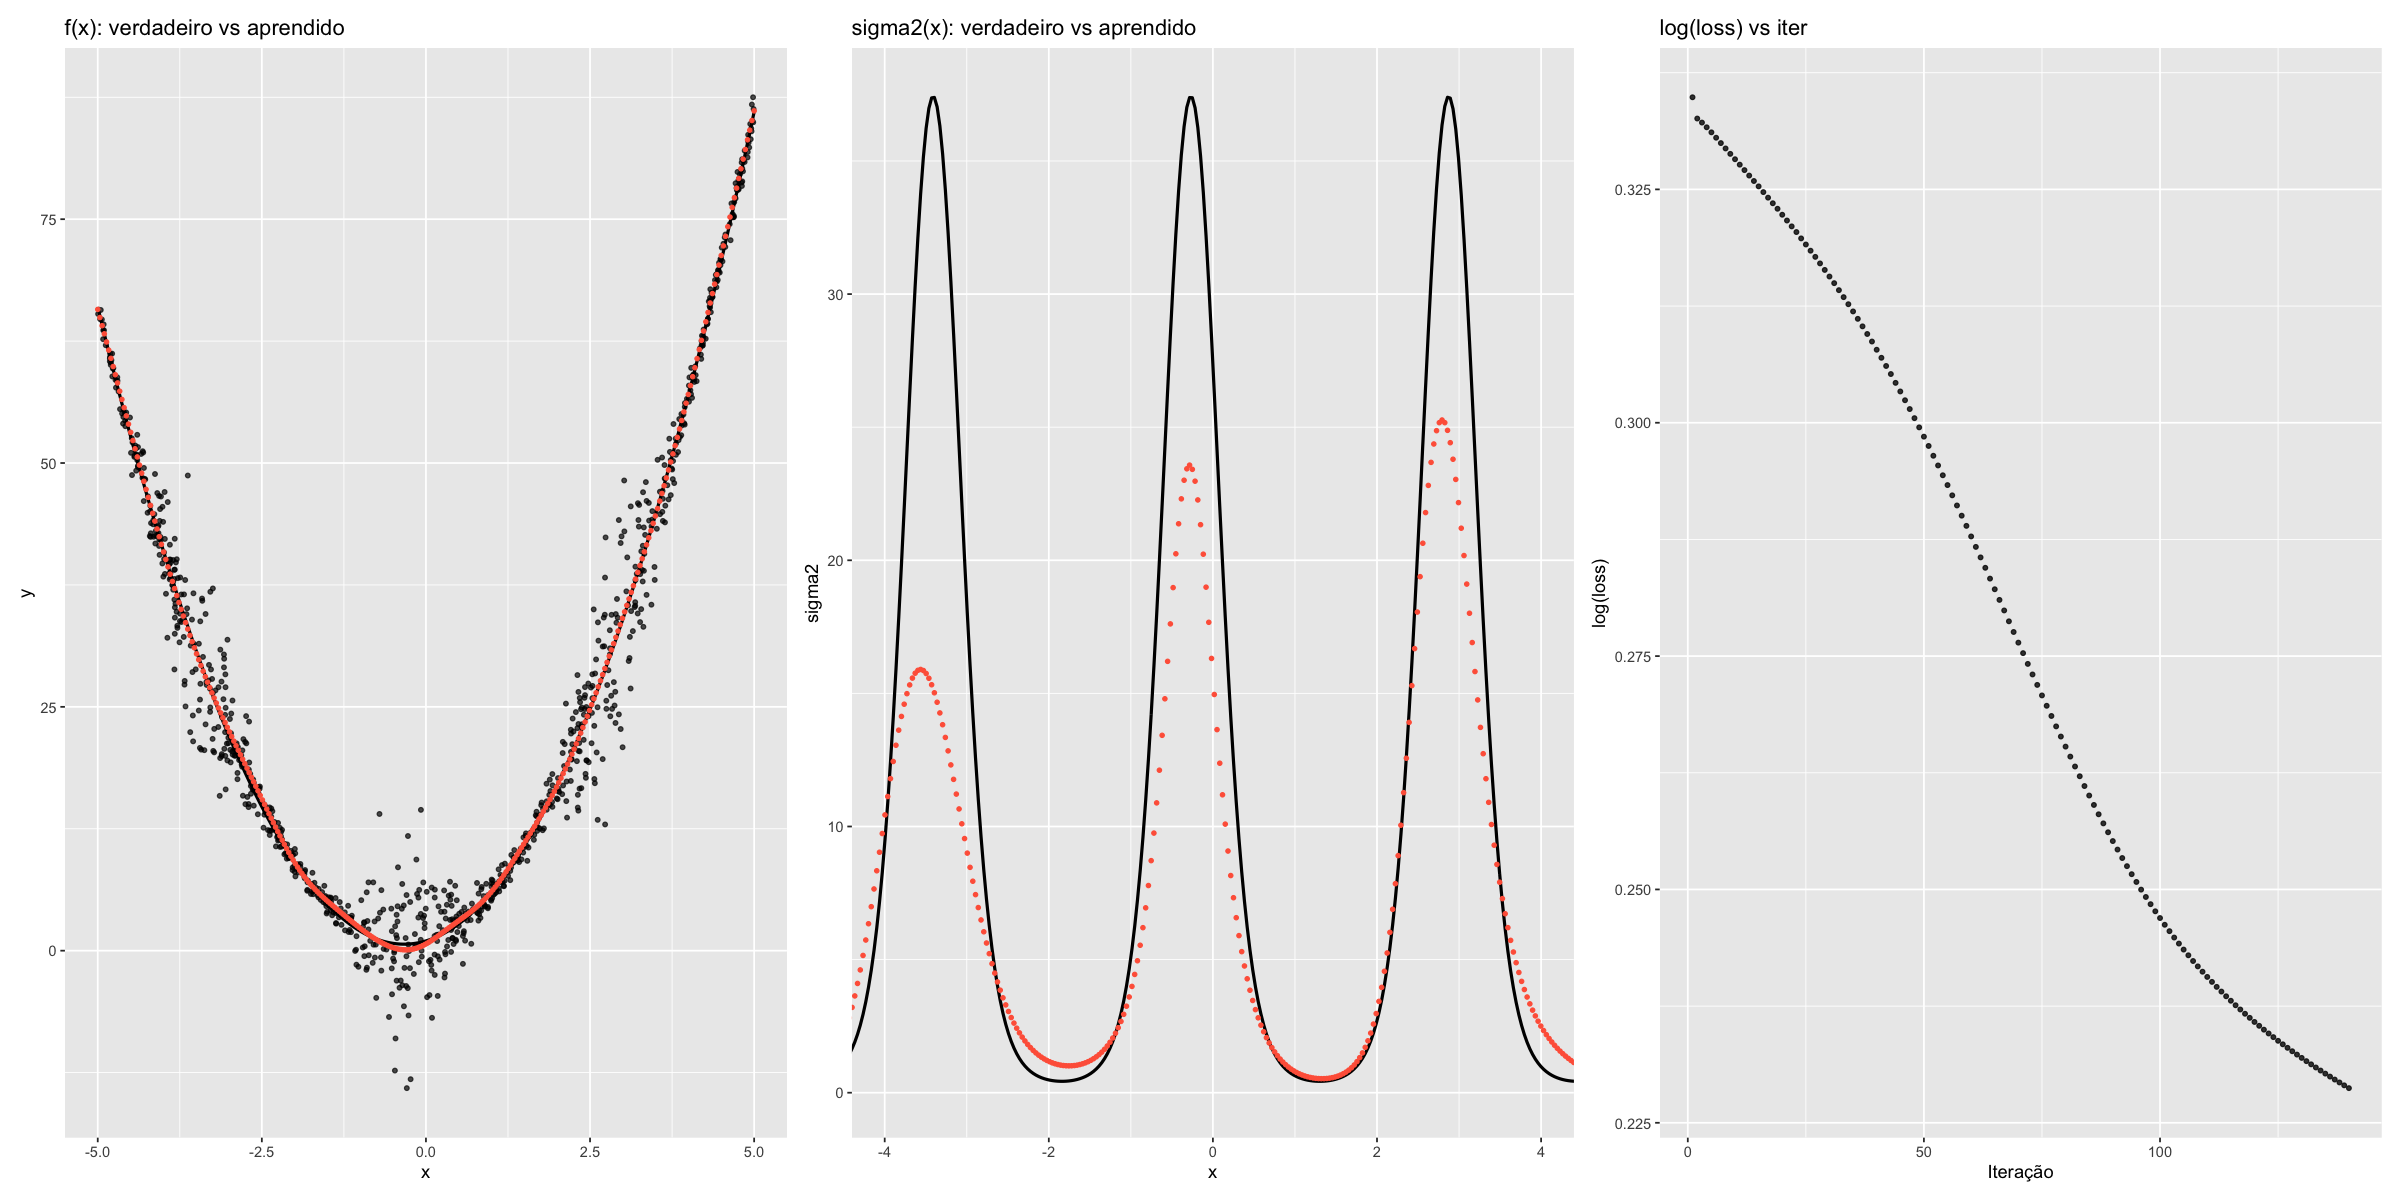

Epoca: 160   Perda: 1.250293
Epoca: 160   Perda: 1.250293


In [ ]:
fit = estimacao(
  x, y, model,
  epochs = 200,
  print_each = 10,
  f = f,
  f_sigma2 = f_sigma2,
  make_gif = TRUE,
  gif_every = 20,
  gif_name = "hetero_train.gif"
)


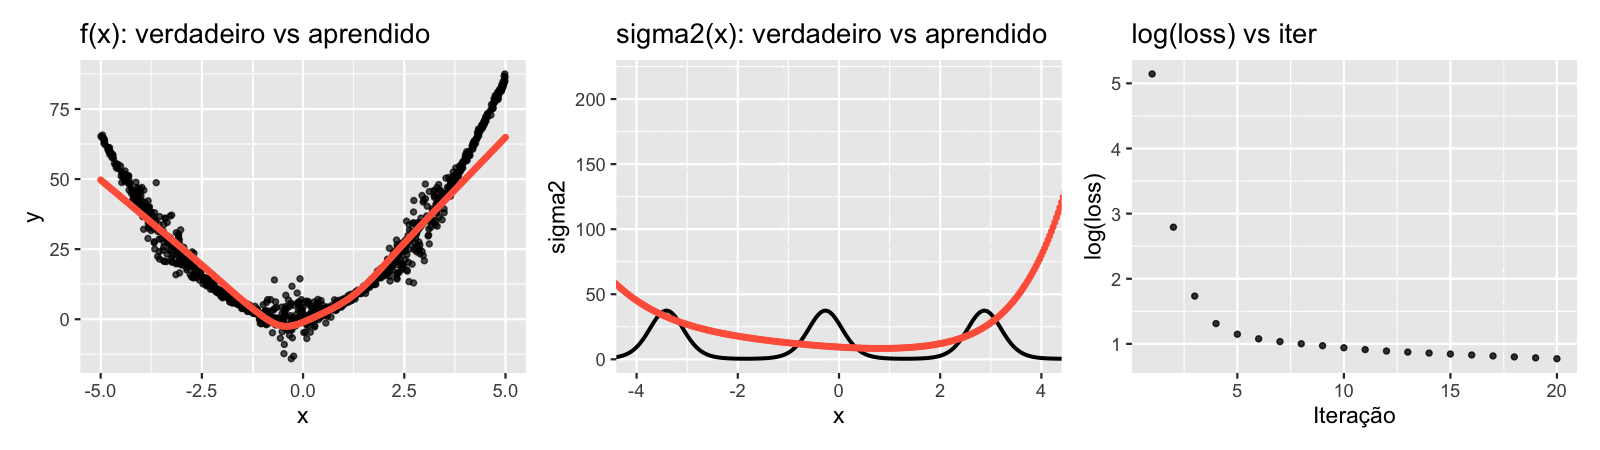

In [57]:
library(IRdisplay)
library(base64enc)

gif_path <- "hetero_train.gif"
gif_raw  <- readBin(gif_path, "raw", n = file.info(gif_path)$size)

gif_b64 <- base64enc::base64encode(gif_raw)

IRdisplay::display_html(
  sprintf(
    '<img src="data:image/gif;base64,%s" style="width:100%%; display:block; margin:auto;">',
    gif_b64
  )
)